In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

try:
    import pyspark
except ImportError:
    import findspark
    findspark.init()
    import pyspark
    
    
# give notebook access to crymepipelines app modules
CRYMEPIPELINES_PATH = '/home/ben/.envs/cc/CrymeClarity/crymepipelines/src'
sys.path.insert(0, CRYMEPIPELINES_PATH)

#build spark session
APP_NAME = 'CRYME_PIPELINE_DEV'
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()


In [2]:
# import cyrmepipelines app modules
import csv
from datetime import datetime, timedelta
import os
import pickle as p
import shutil

from shared.objects.samples import SamplesManager
from shared.settings import CF_TRUST_DELAY, START_DATE, cf_conn, cp_conn, TMP_DIR, BIN_DIR
from tasks.base import SparkCrymeTask, NativeCrymeTask
from utils import crime_occ_udf, ts_to_minutes_in_day_udf, ts_to_hour_of_day_udf, ts_to_day_of_week_udf, ts_conv, safety_rel_crimes
from tasks.mixins import SearchForCrimesMixin

In [23]:
crime_incidents = spark.read.parquet(CRYMEPIPELINES_PATH+'/tmp/clean_crime_incidents.parquet')


In [4]:
by_type = crime_incidents.groupBy('premis_desc').agg({'_id': 'count'}).orderBy("count(_id)", ascending=False)
by_type.show(by_type.count(), False)

+---------------------------------------------------------------+----------+
|premis_desc                                                    |count(_id)|
+---------------------------------------------------------------+----------+
|STREET                                                         |46907     |
|SINGLE FAMILY DWELLING                                         |26664     |
|MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)                   |19074     |
|PARKING LOT                                                    |15497     |
|SIDEWALK                                                       |10403     |
|OTHER BUSINESS                                                 |8105      |
|VEHICLE, PASSENGER/TRUCK                                       |7674      |
|DRIVEWAY                                                       |3942      |
|GARAGE/CARPORT                                                 |3714      |
|RESTAURANT/FAST FOOD                                           |3066      |

In [24]:
ci = crime_incidents.filter(crime_incidents.longitude < 34.082340)
ci = ci.filter(ci.longitude > 34.046290)
ci = ci.filter(ci.latitude > -118.466994)
ci = ci.filter(ci.latitude < -118.413949)


In [25]:
by_type = ci.groupBy('date_occ').agg({'_id': 'count'}).orderBy("date_occ")


In [26]:
data = by_type.collect()

Text(0.5, 1.0, 'Crime Volume in Westwood (Last Year)')

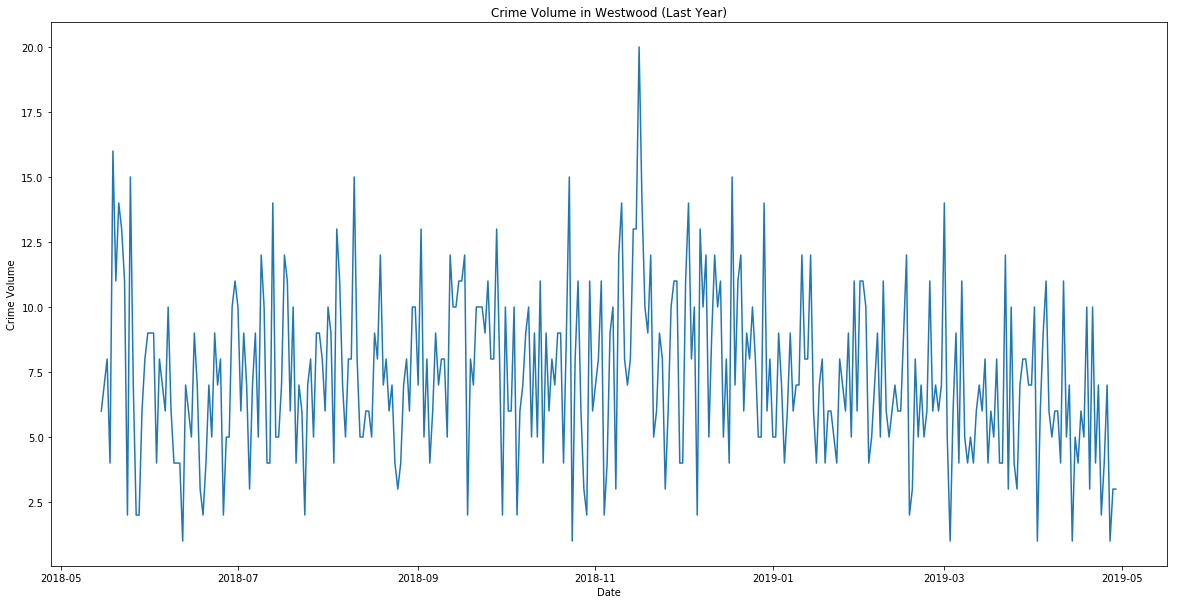

In [27]:
plt.figure(figsize=(20,10)) 
plt.plot([i[0] for i in data],[i[1] for i in data])
plt.xlabel('Date')
plt.ylabel('Crime Volume')
plt.title('Crime Volume in Westwood (Last Year)')

Looks like a pretty uninteresting time series, maybe some seasonality to it.

Lets take a look at the volume of a specific crime over time throughout the entire city.

In [28]:
ci = crime_incidents.filter(crime_incidents.crm_cd==310)
by_type = ci.groupBy('date_occ').agg({'_id': 'count'}).orderBy("date_occ")
data = by_type.collect()

Text(0.5, 1.0, 'City of LA burglary volume by day')

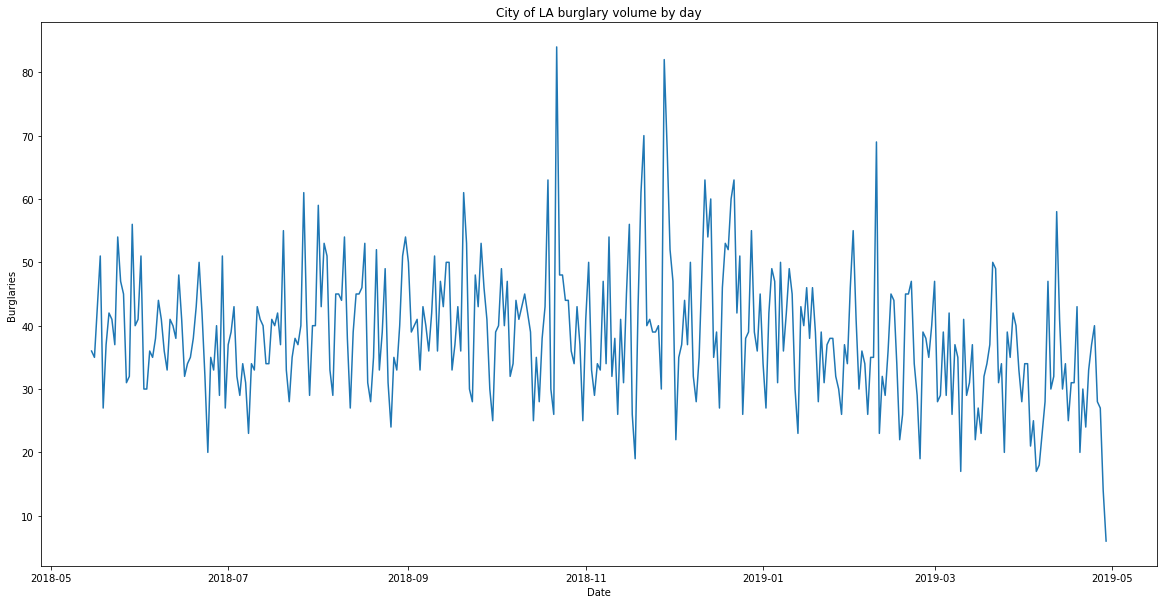

In [29]:
plt.figure(figsize=(20,10)) 
plt.plot([i[0] for i in data],[i[1] for i in data])
plt.xlabel('Date')
plt.ylabel('Burglaries')
plt.title('City of LA burglary volume by day')

In [30]:
ci = crime_incidents.filter(crime_incidents.longitude < 34.063782)
ci = ci.filter(ci.longitude > 34.024901)
ci = ci.filter(ci.latitude > -118.556265)
ci = ci.filter(ci.latitude < -118.497482)
ci = ci.filter(ci.crm_cd==310)


Text(0.5, 1.0, 'Pacific Palisades Burglaries by Daily Volume')

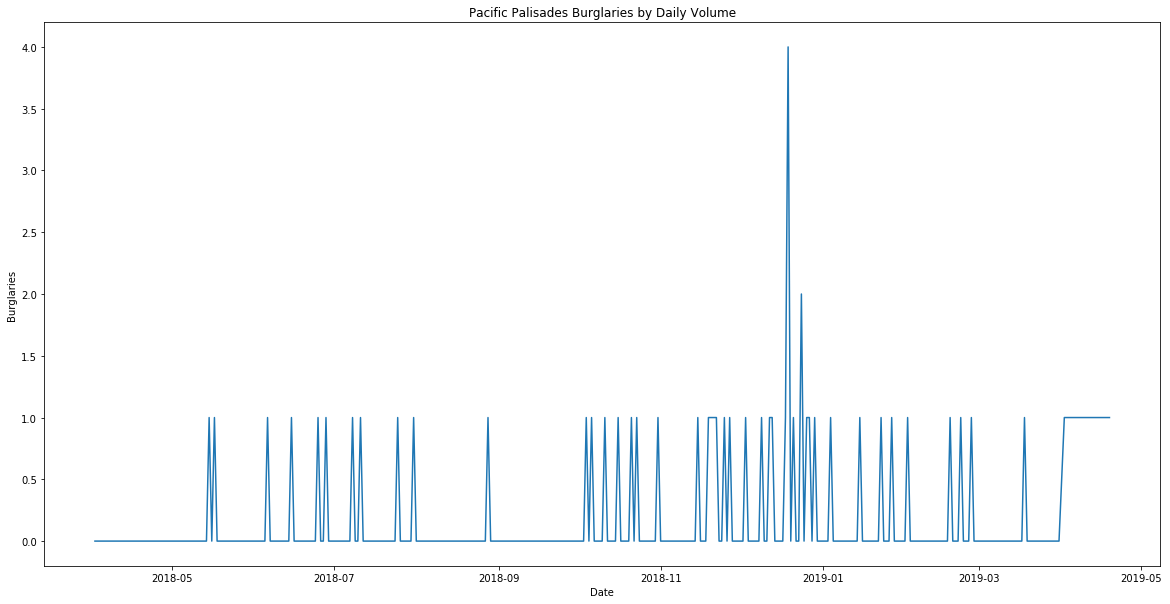

In [31]:
by_type = ci.groupBy('date_occ').agg({'_id': 'count'}).orderBy("date_occ")
data = by_type.collect()
plt.figure(figsize=(20,10)) 
data = by_type.collect()
vols = {(datetime(year=2018, month=4, day=1)+ timedelta(days=i)): 0 for i in range(1,365)}
for i in data:
    vols[i[0]] = i[1]
plt.plot(vols.keys(), vols.values())
plt.xlabel('Date')
plt.ylabel('Burglaries')
plt.title('Pacific Palisades Burglaries by Daily Volume')

Text(0.5, 1.0, 'Palisades Daily Burglaries Autocorrelation')

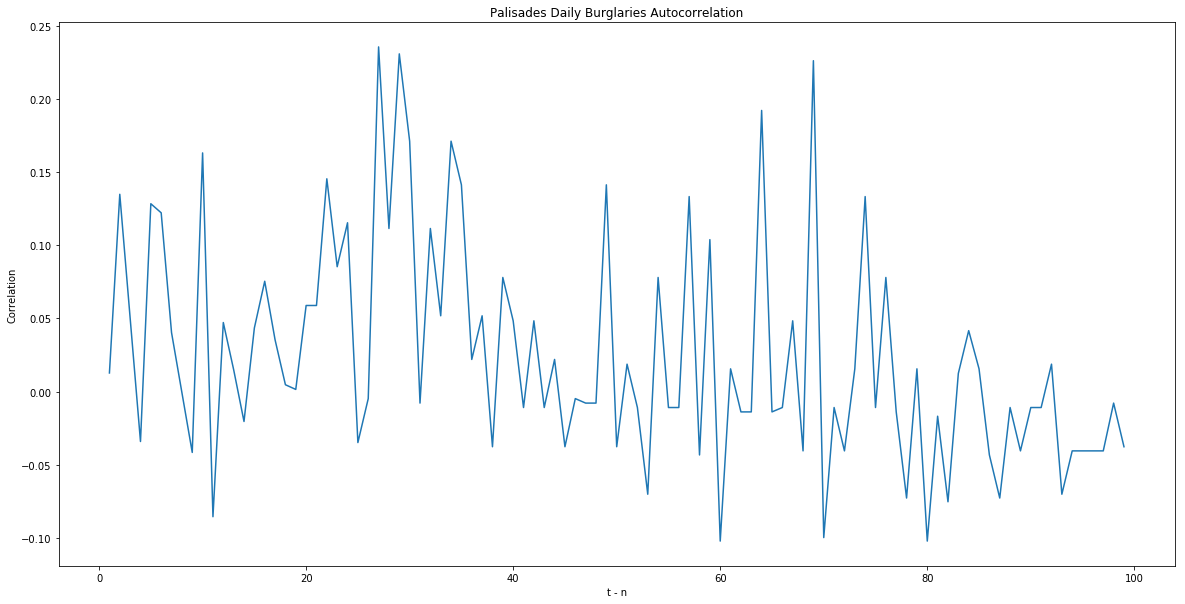

In [36]:
t = []
c = []
x = np.array(list(vols.values()))

for i in range(1, 100):
    t.append(i)
    c.append(np.corrcoef(x[0:250], x[0+i:250+i])[0][1])
    
plt.figure(figsize=(20,10)) 
plt.plot(t, c)
plt.xlabel('t - n')
plt.ylabel('Correlation')
plt.title('Palisades Daily Burglaries Autocorrelation')

There doesnt appear to be much of a relationship between any time interval delay of the time series and itself.